# Introduction to Recurrent Neural Network Models

Recurrent neural networks (RNN) are a deep architecture designed to deal with sequential data. There are many types of sequential data such as audio, video, text and time series data. RNNs consume sequential data by processing each timestep one at a time. For each timestep processed, the RNN produces an output and a hidden state. The hidden state is passed into the next timestep and is involved in the computation. This implies that when processing a certain timestep in a sequence, the network is aware of the current timestep and everything that came before. Additionally, the model weights used for computing the outputs and hidden states are shared across time. Meaning that the model learns a time invariant mapping allowing it to handle an input sequence of any size. The general RNN architecture layout is shown in the diagram below. $X_i$ represents the input data, $h_i$ represents the hidden state and $y_i$ represents the output at timestep $i$.

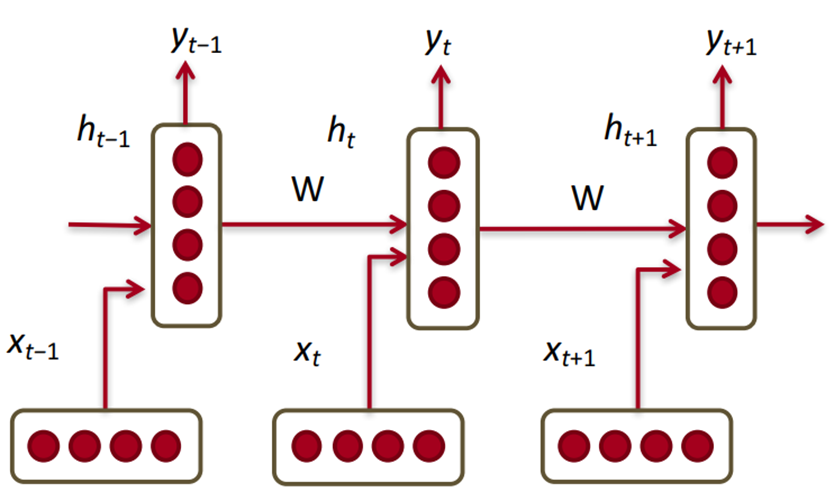


It is worth mentioning that the traditional RNN architecture suffers from vanishing and exploding gradient problems during training. Long short-term memory (LSTM) and gated recurrent units (GRU) are variants of the traditional RNN that remedy the vanishing gradient problem by modifying the cell computation and introducing new computational units called gates. These gates also improve the way information is propagated through time by learning which information to retain and which to forget. In most cases, either an LSTM or GRU are used instead of the traditional RNN.

There are several RNN configurations that change the format of the input and output:
- **One-to-one**: this reduces to a simple neural network and is rarely used.
- **One-to-many**: the input has only one timestep while the output has many. An example use case is language generation.
- **Many-to-one**: the input has many timesteps while the output has only one. An example use case is sentiment analysis.
- **Many-to-many**: both the input and output have many timesteps which may or may not be equal in size. An example use case is machine translation.

In this notebook, we will demonstrate two common applications of RNN: emotion classification which is a case of many-to-one and machine translation which is many-to-many.

## Emotion Classification

The first task is a simple emotion classification problem. Given a text sentence, our goal is to predict the kind of emotion expressed in this sentence.

We will be using the [Contextualized Affect Representations for Emotion Recognition](https://www.kaggle.com/datasets/parulpandey/emotion-dataset) dataset which contains sentences labeled a expressing one of six emotions.

We begin by downloading the dataset and loading it into a Pandas DataFrame and showing some examples.

In [2]:
#seed everything
from tensorflow.keras.utils import set_random_seed
set_random_seed(1)

In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/parulpandey/emotion-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mariethereseyounan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/parulpandey/emotion-dataset


100%|██████████| 715k/715k [00:00<00:00, 96.0MB/s]

In [5]:
import pickle
import pandas as pd

df_train = pd.read_csv('emotion-dataset/training.csv')
df_test = pd.read_csv('emotion-dataset/test.csv')

##1) Data Preprocessing

- For each datasets, plot the histogram of "emotions" to see the different classes and their distribution.

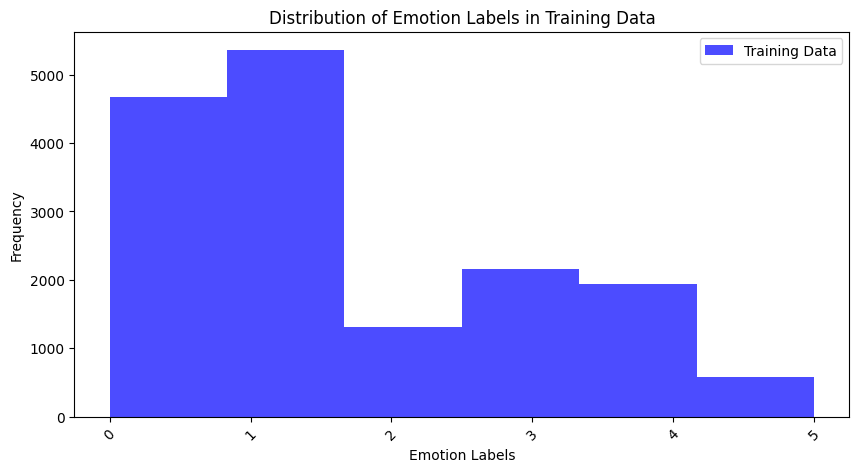

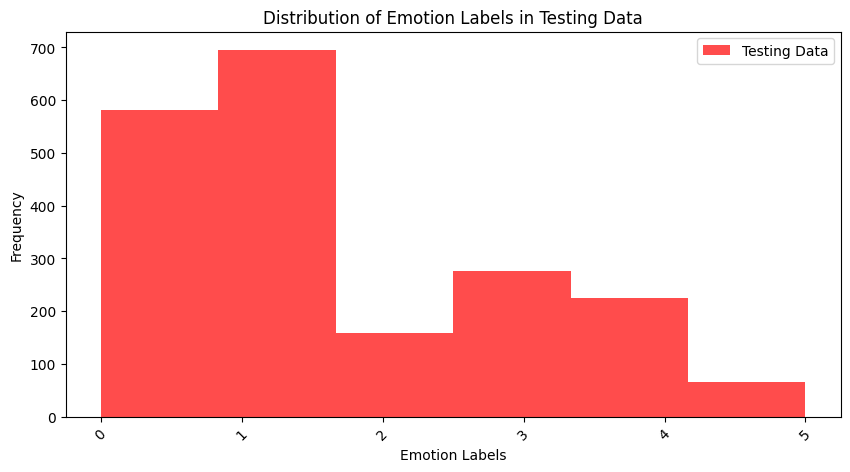

In [6]:
import matplotlib.pyplot as plt
#plot the histogram of the training dataset
plt.figure(figsize=(10, 5))
plt.hist(df_train['label'], bins=len(df_train['label'].unique()), alpha=0.7, color='blue', label='Training Data')
plt.title('Distribution of Emotion Labels in Training Data')
plt.xlabel('Emotion Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#plot the histogram of the testing dataset
plt.figure(figsize=(10, 5))
plt.hist(df_test['label'], bins=len(df_test['label'].unique()), alpha=0.7, color='red', label='Testing Data')
plt.title('Distribution of Emotion Labels in Testing Data')
plt.xlabel('Emotion Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

- Convert the "label" column into one-hot encoding format.
- Build a dictionary to map the one-hot encoded labels back to string form. This dictionary will be useful later when using our model to make predictions.

In [7]:
df_train = pd.get_dummies(df_train, columns=['label'])
df_train.head()

df_test = pd.get_dummies(df_test, columns=['label'])
df_test.head()

,text,label_0,label_1,label_2,label_3,label_4,label_5
0,im feeling rather rotten so im not very ambiti...,True,False,False,False,False,False
1,im updating my blog because i feel shitty,True,False,False,False,False,False
2,i never make her separate from me because i do...,True,False,False,False,False,False
3,i left with my bouquet of red and yellow tulip...,False,True,False,False,False,False
4,i was feeling a little vain when i did this one,True,False,False,False,False,False


In [8]:
print(df_train.columns)

Index(['text', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4',
       'label_5'],
      dtype='object')


In [9]:
label_tostr = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
print(label_tostr)

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


- Separate the data and the labels into two arrays (X and y) both for train and test datasets.

In [10]:
from sklearn.model_selection import train_test_split

X_train = df_train['text'].values
y_train = df_train.drop('text', axis=1).values

X_test = df_test['text'].values
y_test = df_test.drop('text', axis=1).values


print("Training Data Input Shape: ", X_train.shape)
print("Training Data Output Shape: ", y_train.shape)
print("###########################################")
print("Testing Data Input Shape: ", X_test.shape)
print("Testing Data Output Shape: ", y_test.shape)

Training Data Input Shape:  (16000,)
Training Data Output Shape:  (16000, 6)
###########################################
Testing Data Input Shape:  (2000,)
Testing Data Output Shape:  (2000, 6)


##2) Classification Model

Until this point, each sample in our training data is a string. In order to input this data into the model, we need to split the sentences into sequences of words and have a numerical representation for each word. As a start we associate each word in the dataset's vocabulary with a unique integer number.

Luckily, Keras provides us with the TextVectorization layer which does all of the above. Namely, this layer according to the default configuration:
- Normalizes the text (lowercase and strip punctuation).
- Tokenizes the text (split into words).
- Learns the dataset vocabulary and associates an integer with each word. A special out of vocabulary (OOV) token is reserved for unseen words.
- Replaces each word with its corresponding integer.

Additionally, this layer can be included as part of our model so we can directly input string data and it will be processed on the fly.

We can then use this data to train an Embedding layer. The Embedding layer learns a mapping from integer number to a high dimensional vector. The purpose of this layer is to learn richer and more semantically oriented vectorized representations of words as opposed to meaningless integers. The word embeddings carry more meaningful representations of words in a way that a well trained embedding layer will reflect the semantic similarity/dissimilarity of two given words in the vector space distance of their respective embeddings.

An embedding layer can be trained on language data separately and fine tuned on the application dataset. In our case, we will simply train as part of the classification model.

The outputs of the embedding layer will be input to the LSTM. Since this is a many-to-one application, we are only interested in the LSTM output at the final timestep because it encompasses the representation of all the timesteps. We connect this output to a fully connected dense layer with a Softmax activation for the classification.

- Initialize the TextVectorization layer and adapt it on the training data.

In [11]:
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf
max_tokens = 16002 #number of unique words in the text
output_sequence_length = 100 #maximum length of our data
# We instantiate the TextVectorization layer and adapt it to our data
vectorizer_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
#adapt the TextVectorization on the training dataset
X_train_texts = df_train['text'].values
vectorizer_layer.adapt(X_train_texts)

- Build the model described above using the Sequential API.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.backend import clear_session

#vocab_size can be obtained from the adapted TextVectorization layer
vocab_size = vectorizer_layer.vocabulary_size()
#embed_dim is the dimension of the word embedding vectors
embed_dim = 128
hidden_dim = 64
num_classes = 6 #our six labeled emotions

clear_session()

model = Sequential()
#add the TextVectorization layer
model.add(vectorizer_layer)
#the input dimension of the Embedding layer is the vocabulary size since it will
#learn a vector representation for each word in the vocabulary
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True))
#we set return_sequences to False because we are only interested in the last output
model.add(LSTM(hidden_dim, return_sequences=False))
model.add(Dense(hidden_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 128)          1947392   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                        

- Train the model and plot the training and validation history.
- Compute the model's classification metrics on the test set.

In [13]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
400/400 [==============================] - 27s 46ms/step - loss: 1.2696 - accuracy: 0.5006 - val_loss: 0.7629 - val_accuracy: 0.7416
Epoch 2/5
400/400 [==============================] - 6s 15ms/step - loss: 0.4544 - accuracy: 0.8520 - val_loss: 0.3575 - val_accuracy: 0.8822
Epoch 3/5
400/400 [==============================] - 6s 15ms/step - loss: 0.2060 - accuracy: 0.9363 - val_loss: 0.4525 - val_accuracy: 0.8878
Epoch 4/5
400/400 [==============================] - 5s 12ms/step - loss: 0.1435 - accuracy: 0.9590 - val_loss: 0.2959 - val_accuracy: 0.9094
Epoch 5/5
400/400 [==============================] - 5s 11ms/step - loss: 0.0884 - accuracy: 0.9728 - val_loss: 0.3604 - val_accuracy: 0.9025


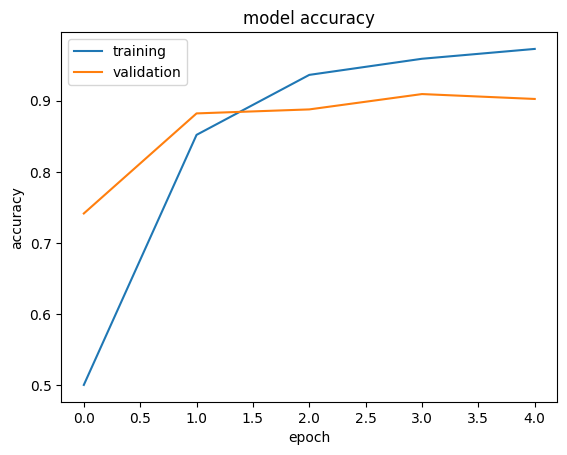

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

In [15]:
import numpy as np
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) #convert predictions to class labels
y_test_classes = np.argmax(y_test, axis=1) #convert the onehot encoded y_test to class labels
print(classification_report(y_test_classes, y_pred_classes)) #print the classification report

63/63 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       581
           1       0.93      0.93      0.93       695
           2       0.75      0.84      0.79       159
           3       0.93      0.85      0.89       275
           4       0.91      0.81      0.86       224
           5       0.67      0.76      0.71        66

    accuracy                           0.90      2000
   macro avg       0.85      0.86      0.85      2000
weighted avg       0.90      0.90      0.90      2000



- Complete the below function to use our model to infer on a given sentence and test it on a few examples.

In [16]:
import tensorflow as tf

def classify_sentence(input_seq, label=None):
    print('Sentence: ' + input_seq)
    if label is not None:
        print('Label: ' + label_tostr[label.argmax()])
    input_seq = tf.constant([input_seq])
    prediction = model.predict(input_seq)
    predicted_label = label_tostr[prediction.argmax(axis=1)[0]]
    print('Prediction: ' + label_tostr[prediction.argmax(axis=1)[0]])
    print('**************************************************************')

In [17]:
classify_sentence(X_test[0], y_test[0])
classify_sentence(X_test[1000], y_test[1000])
classify_sentence(X_test[20], y_test[20])
classify_sentence(X_test[7], y_test[7])

Sentence: im feeling rather rotten so im not very ambitious right now
Label: sadness
1/1 [==============================] - 0s 33ms/step
Prediction: sadness
**************************************************************
Sentence: i grew up around this feeling living only minutes away from the gorgeous atlantic ocean in brazil so its probably no surprise i grew fond of the ocean
Label: joy
1/1 [==============================] - 0s 35ms/step
Prediction: joy
**************************************************************
Sentence: im not sure the feeling of loss will ever go away but it may dull to a sweet feeling of nostalgia at what i shared in this life with my dad and the luck i had to have a dad for years
Label: sadness
1/1 [==============================] - 0s 29ms/step
Prediction: love
**************************************************************
Sentence: i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i shoul

## Neural Machine Translation with Seq2seq Models

Machine translation is the simple task of translating a text from one language to another. Neural machine translation is at the core of many popular translation services such as Google Translate.

One of the most common architectures for machine translation is the RNN encoder-decoder layout. In this method, an input encoder RNN consumes the input text as a sequence of tokens (represented by word embeddings). At the last time step, the hidden state of this RNN is considered to be a context vector summarizing the entire input sequence. This context vector is given to another decoder RNN as an initial hidden state. At each time step, the output of the decoder is fed through a fully connected softmax layer which predicts a token. As the decoder input, the simplest approach is to use the output from the previous timestep (starting with the start of sequence \<SOS> token). A more effective approach would be to input the ground truth translations at each timestep instead of the model's translations (which would be in many cases during training wrong). This approach is called teacher forcing and it helps the model converge faster.

This architecture is called sequence to sequence (Seq2seq) since it produces a sequence of tokens from an input sequence. It has many different applications aside from machine translation such as image captioning.

In this notebook, we will implement a basic Seq2seq model for machine translation. We will also implement Attention, which is a mechanism that addresses a key bottleneck in Seq2seq models.

To begin, let's download the data from this [collection](https://www.manythings.org/anki/) of different English translations. We will use English to French translations. In any case, it is always better to select a language that you understand so that you can assess the quality of the model's translations.

In [18]:
!wget -q http://www.manythings.org/anki/fra-eng.zip
!unzip -q fra-eng.zip
!rm fra-eng.zip

##3) Data Loading and Preprocessing

The data is presented in a tab-separated format. The third column provides the attribution which we do not need. We can easily read this data into a Pandas DataFrame.

In order to reduce the training time we will first limit our dataset by the length of the sentences. If we look at the first few samples, we see that there are duplicate sentences for which are provided different translations. We will also discard these to further reduce the size of our dataset given that many of them simply differ in terms of punctuation and not actual translation.

We then split the data into training and testing sets.

- Load the data into a DataFrame.
- Complete the code to remove short and long sentences.
- Complete the code to drop duplicate samples.

In [19]:
import pandas as pd

dataset = pd.read_csv('fra.txt', sep='\t', usecols=[0,1], names=['en', 'fr'])

#remove short sentences
dataset = dataset[dataset['en'].map(str.split).map(len) > 2].copy()
#remove long sentences to reduce processing and training time
dataset = dataset[dataset['en'].map(str.split).map(len) <= 10].copy()
#remove duplicate sentences
dataset.drop_duplicates(subset=['en', 'fr']).reset_index(drop=True)
dataset.head()

,en,fr
481,Am I fat?,Suis-je gros ?
482,Am I fat?,Suis-je grosse ?
493,Be a man.,Sois un homme !
494,Be a man.,Soyez un homme !
508,Can I go?,Je peux y aller ?


- Complete the code to split the data.

In [20]:
from sklearn.model_selection import train_test_split

X = dataset['en'] #input the English sentences
y = dataset['fr'] #output or target is the French translations

X_train_enc, X_test_enc, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Data Input Shape: ", X_train_enc.shape)
print("Training Data Output Shape: ", y_train.shape)
print("Testing Data Input Shape: ", X_test_enc.shape)
print("Testing Data Output Shape: ", y_test.shape)

Training Data Input Shape:  (171676,)
Training Data Output Shape:  (171676,)
Testing Data Input Shape:  (42920,)
Testing Data Output Shape:  (42920,)


We add \<SOS> (start of sentence) and \<EOS> (end of sentence) tokens at the beginning and end of our sentences. More specifically, we add both to the encoder input data. We add only the \<SOS> token to the decoder (teacher forcing) input and only the \<EOS> token to the decoder target. This time shift between the teacher forcing input and the target is meant to desynchronize the two sequences and prevent the decoder from learning to simply copy the input to the output.

- Complete the lambda function below.

In [21]:
import numpy as np

add_eos = lambda x: x + ' <EOS>' #eos end of sentence
v_add_eos = np.vectorize(add_eos)
add_sos = lambda x: '<SOS> ' + x #sos start of sentence
v_add_sos = np.vectorize(add_sos)

X_train_enc = v_add_sos(v_add_eos(X_train_enc)) #encoder input
X_test_enc = v_add_sos(v_add_eos(X_test_enc)) #encoder input
X_train_dec = v_add_sos(y_train) #decoder input
X_test_dec = v_add_sos(y_test) #decoder input
y_train = v_add_eos(y_train) #decoder ground truth
y_test = v_add_eos(y_test) #decoder ground truth

- Define and adapt the TextVectorization layers. Define a separate layer for each of the source and target languages.

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

#first we need to define a normalization function for preprocessing the text
def normalize_string(s):
    #Lets say we need to convert to lowercase and strip whitespace
    s = tf.strings.lower(s)
    s = tf.strings.strip(s)
    return s

src_vectorizer = TextVectorization(standardize=normalize_string) #for the source which is English
src_vectorizer.adapt(X_train_enc)
trg_vectorizer = TextVectorization(standardize=normalize_string) #for the target which is French translation
trg_vectorizer.adapt(np.concatenate([X_train_dec,y_train]))

src_vocab_size = len(src_vectorizer.get_vocabulary())
trg_vocab_size = len(trg_vectorizer.get_vocabulary())
#print the sizes
print("Source Vocabulary Size:", src_vocab_size)
print("Target Vocabulary Size:", trg_vocab_size)

Source Vocabulary Size: 25299
Target Vocabulary Size: 44693


##4) Seq2seq Model

Now we define the LSTM Seq2seq model described above and shown in the diagram below ([source](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)).

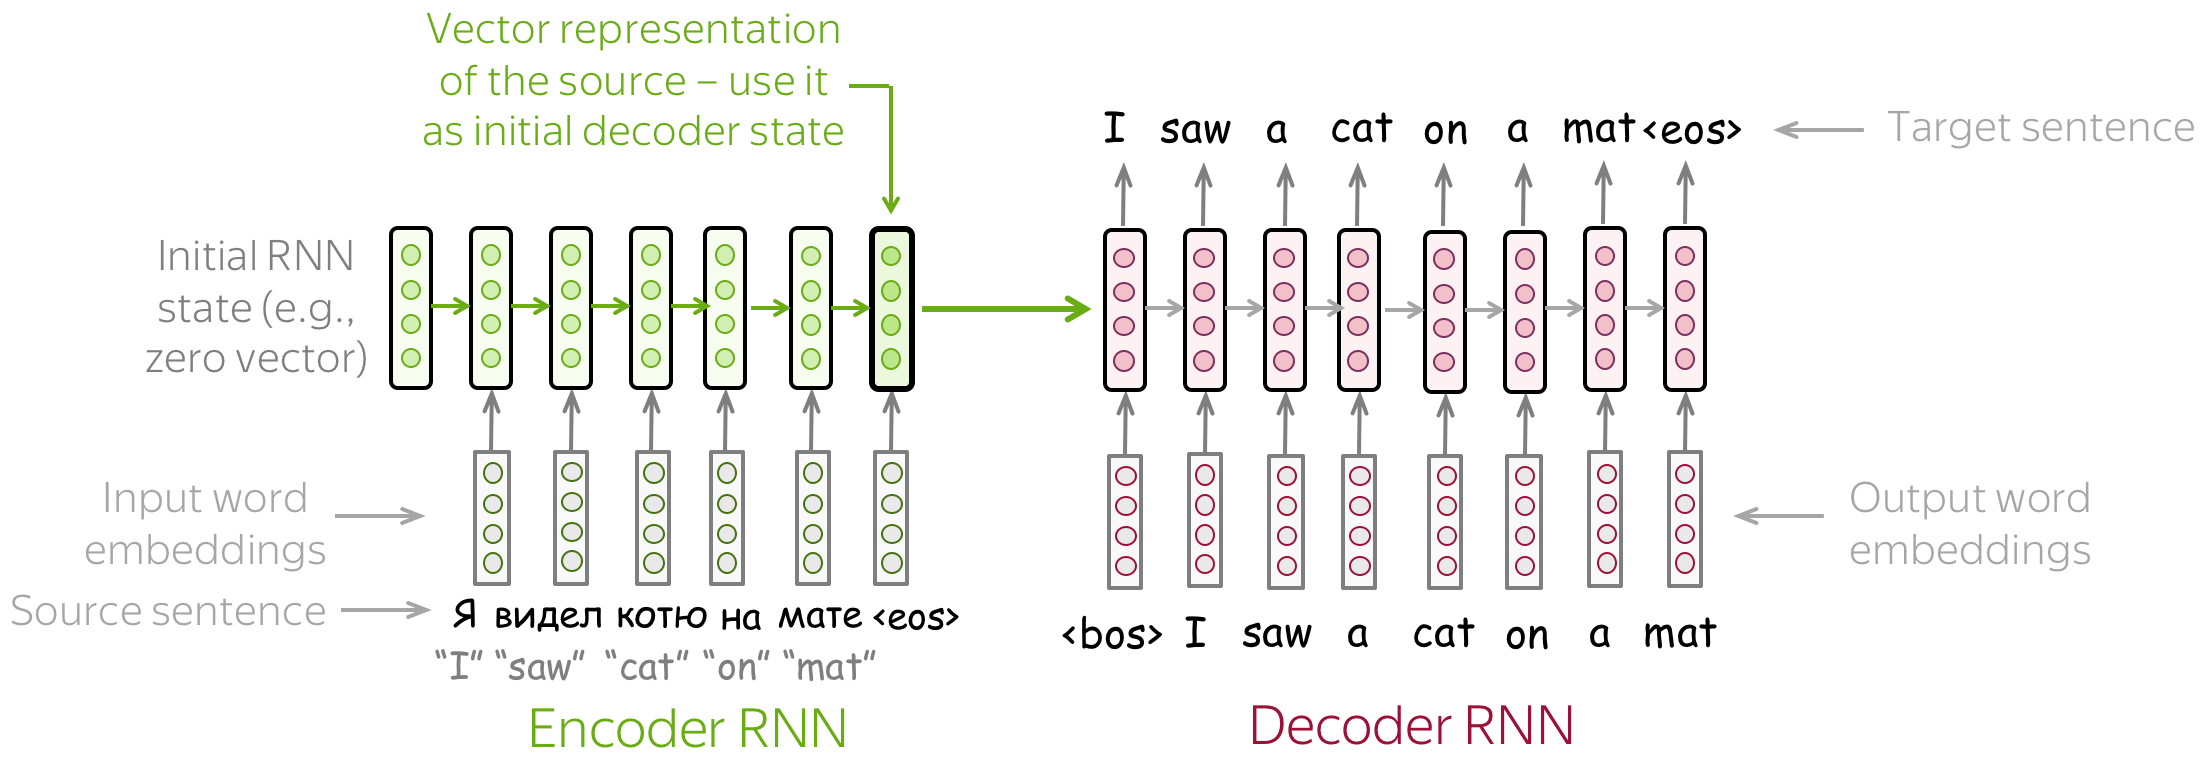

When we defined the emotion classification model earlier, we used the Keras Sequential API. The Sequential model is ideal when the desired architecture is made of linealry stacked layers where each layer's output is the input to the next layer.

However, that is not the case when it concerns our Seq2seq model. Therefore, we use the Keras Functional Model which allows the definition of more complex non-linear architectures.

- Define the model descibed above using the Functional API.

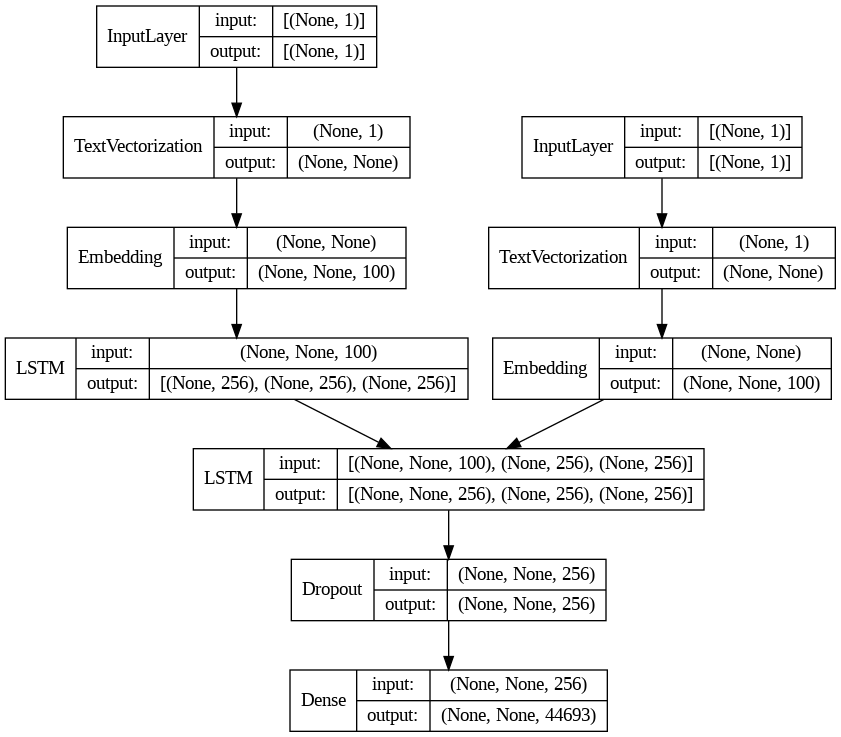

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session

hidden_dim = 256
embed_dim = 100

clear_session()

#define an input sequence and process it
encoder_inputs = Input(shape=(1,), dtype='string') #batch_size, 1
encoder_inputs_vec = src_vectorizer(encoder_inputs) #batch_size, src_len
encoder_inputs_emb = Embedding(input_dim=src_vocab_size, output_dim=embed_dim, mask_zero=True)(encoder_inputs_vec) #batch_size, src_len, embed_dim
#define the encoder lstm
#we only need the last hidden state
_, state_h, state_c = LSTM(units=hidden_dim, return_state=True, dropout=0.5)(encoder_inputs_emb) #batch_size, hidden_dim
encoder_states = [state_h, state_c]

#define the decoder, using encoder_states as initial state
decoder_inputs = Input(shape=(1,), dtype='string') #batch_size, 1
decoder_inputs_vec = trg_vectorizer(decoder_inputs) #batch_size, trg_len
decoder_inputs_emb = Embedding(input_dim=trg_vocab_size, output_dim=embed_dim, mask_zero=True)(decoder_inputs_vec) #batch_size, trg_len, embed_dim
#we set up our decoder to return full output sequences, and to return internal states as well
#we don't use the return states in the training model, but we will use them in inference
decoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_emb, initial_state=encoder_states) #batch_size, trg_len, hidden_dim
decoder_outputs = Dropout(0.5)(decoder_outputs)
#use a dense layer to classify each output as one of the words in the vocab
decoder_dense = Dense(units=trg_vocab_size, activation='softmax')
outputs = decoder_dense(decoder_outputs) #batch_size, trg_len, trg_vocab_size

#define and visualize the end-to-end model
model = Model([encoder_inputs, decoder_inputs], outputs)

plot_model(model, show_shapes=True, show_layer_names=False)

Before we proceed to train the model, we must properly represent the target data (y_train and y_test) which is still in string format.

To avoid having to store y_train and y_test in vector format, we define a custom loss function which vectorizes its target argument using the TextVectorization layer before computing the loss. We also use the Sparse Categorical Crossentropy loss instead of the traditional Categorical Crossentropy loss since the former accepts the target in integer format as opposed to one-hot format.

- Complete the code below to define the custom loss function.

In [24]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss_fn = SparseCategoricalCrossentropy()

def custom_sparse_categorical_crossentropy(y_true, y_pred):
    y_true = trg_vectorizer(y_true)
    return loss_fn(y_true, y_pred)

- Compile and train the model.
- Plot the training and validation loss history.

Epoch 1/5
135/135 [==============================] - 113s 761ms/step - loss: 6.9035 - val_loss: 6.0914
Epoch 2/5
135/135 [==============================] - 92s 685ms/step - loss: 5.8922 - val_loss: 5.6405
Epoch 3/5
135/135 [==============================] - 89s 662ms/step - loss: 5.5040 - val_loss: 5.3549
Epoch 4/5
135/135 [==============================] - 86s 636ms/step - loss: 5.2249 - val_loss: 5.0663
Epoch 5/5
135/135 [==============================] - 85s 628ms/step - loss: 4.9450 - val_loss: 4.8069


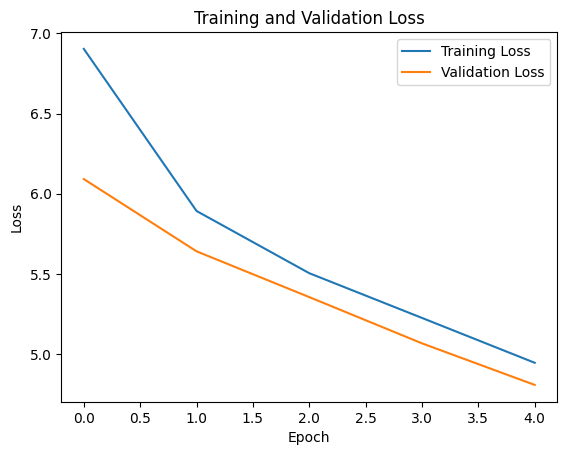

In [25]:
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
model.compile(loss=custom_sparse_categorical_crossentropy, optimizer='adam')
history = model.fit([X_train_enc, X_train_dec], y_train, epochs=5, batch_size=1024, validation_split=0.2)
#plot training and validation loss history
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##5) Seq2seq Inference Model

The inference model needs to be implemented separately from the training model. During inference, we cannot use teacher forcing since target data is not available during inference. The decoder input is the output of the previous time step. Therefore, we need to manually code the decoding timesteps in a loop to implement this mechanism. Also, we check at each timestep if the output is the \<EOS> sequence to terminate the sequence.

- Complete the code below to define the inference model.


In [26]:
#define inference model
#note that this definition will use the same layer instances defined and trained earlier

#encoder same as before
encoder_model = Model(encoder_inputs, encoder_states)

#define decoder state inputs which will be intialized with the encoder states
decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#define decoder
#decoder states will be used as decoder state inputs while looping
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_emb, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

output = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [output] + decoder_states)

- Complete the code below to define the translation routine then test it on a few samples.

In [27]:
import tensorflow as tf

#we extract the vocabulary from the TextVectorization layer in order to inverse the mapping (from integer to string)
trg_vocab = trg_vectorizer.get_vocabulary()

def translate_sentence(input_seq, target=None):
    print('Source: ' + input_seq)
    if target is not None:
        print('Target: ' + target)

    #convert string to array
    input_seq = np.array(input_seq).reshape(1,1)
    #encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    #populate the first token of the decoder input with the start token
    dec_in = tf.reshape(tf.constant(['<SOS>']), (1,1))
    decoded_sentence = ''
    stop_condition = False

    while not stop_condition:
        #decode
        output_tokens, h, c = decoder_model.predict([dec_in]+states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = trg_vocab[sampled_token_index]
        #store output
        decoded_sentence = decoded_sentence + ' ' + sampled_word

        #stop condition either hit max length or find stop token
        #stop token is eos and not <EOS> due to text normalization
        if (sampled_word == 'eos' or len(decoded_sentence.split()) > 30):
            stop_condition = True

        #update the next decoder input
        dec_in = tf.reshape(tf.constant([sampled_word]), (1,1))

        #update states
        states_value = [h, c]

    print('Translation: ' + decoded_sentence)
    print('****************************************************')

In [28]:
translate_sentence(X_test_enc[20], y_test[20])
translate_sentence(X_test_enc[200], y_test[200])
translate_sentence(X_test_enc[450], y_test[450])
translate_sentence(X_test_enc[788], y_test[788])

Source: <SOS> I hate what I've become. <EOS>
Target: Je déteste ce que je suis devenue. <EOS>
1/1 [==============================] - 0s 19ms/step
Translation:  je ne suis pas de la train de la maison. <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ?
****************************************************
Source: <SOS> We've forgotten something. <EOS>
Target: Nous avons oublié quelque chose. <EOS>
1/1 [==============================] - 0s 22ms/step
Translation:  je ne suis pas de la maison. <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ?
****************************************************
Source: <SOS> I returned to my seat. <EOS>
Target: J'ai regagné mon siège. <EOS>
1/1 [==============================] - 0s 19ms/step
Translation:  je suis un chose de la maison. <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ? <eos> <eos> ?
****

##6) Attention Seq2seq Model

A major shortcoming of the traditional Seq2seq model is that the decoder has to rely on only a single vector produced by the encoder to represent the full input sequence. Attention seeks to mitigate this by informing the decoder which parts of the input sequence (encoder outputs) to "pay more attention to" at each time step. This mechanism learns to produce these attention weights according to the following process.

At each decoder time step:
- Attention score is calculated from all the encoder outputs and the current decoder output. This attention score indicates how relevant each encoder output is with respect to the current decoder output.
- A softmax operation is applied on the scores to turn the scores into a probability distribution (called attention weights).
- The attention output is a linear combination of the attention weights and the encoder outputs.
- The attention output is then combined with the decoder output to be used as input for the softmax classifier.

There are many different flavors of attention. They mainly differ in how they implement the following functions:
- How to calculate the attention score.
- How to combine the attention output with the decoder output.

In this notebook, we will implement the [Luong](https://arxiv.org/abs/1508.04025) variant which uses the following calculations:
- A bilinear function for the attention score involving a matrix of learnable weights.
- A concatenation of the attention output and decoder output through a linear layer with tanh non-linearity.

The architecture of the Luong attention is shown in the below diagram ([source](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)).

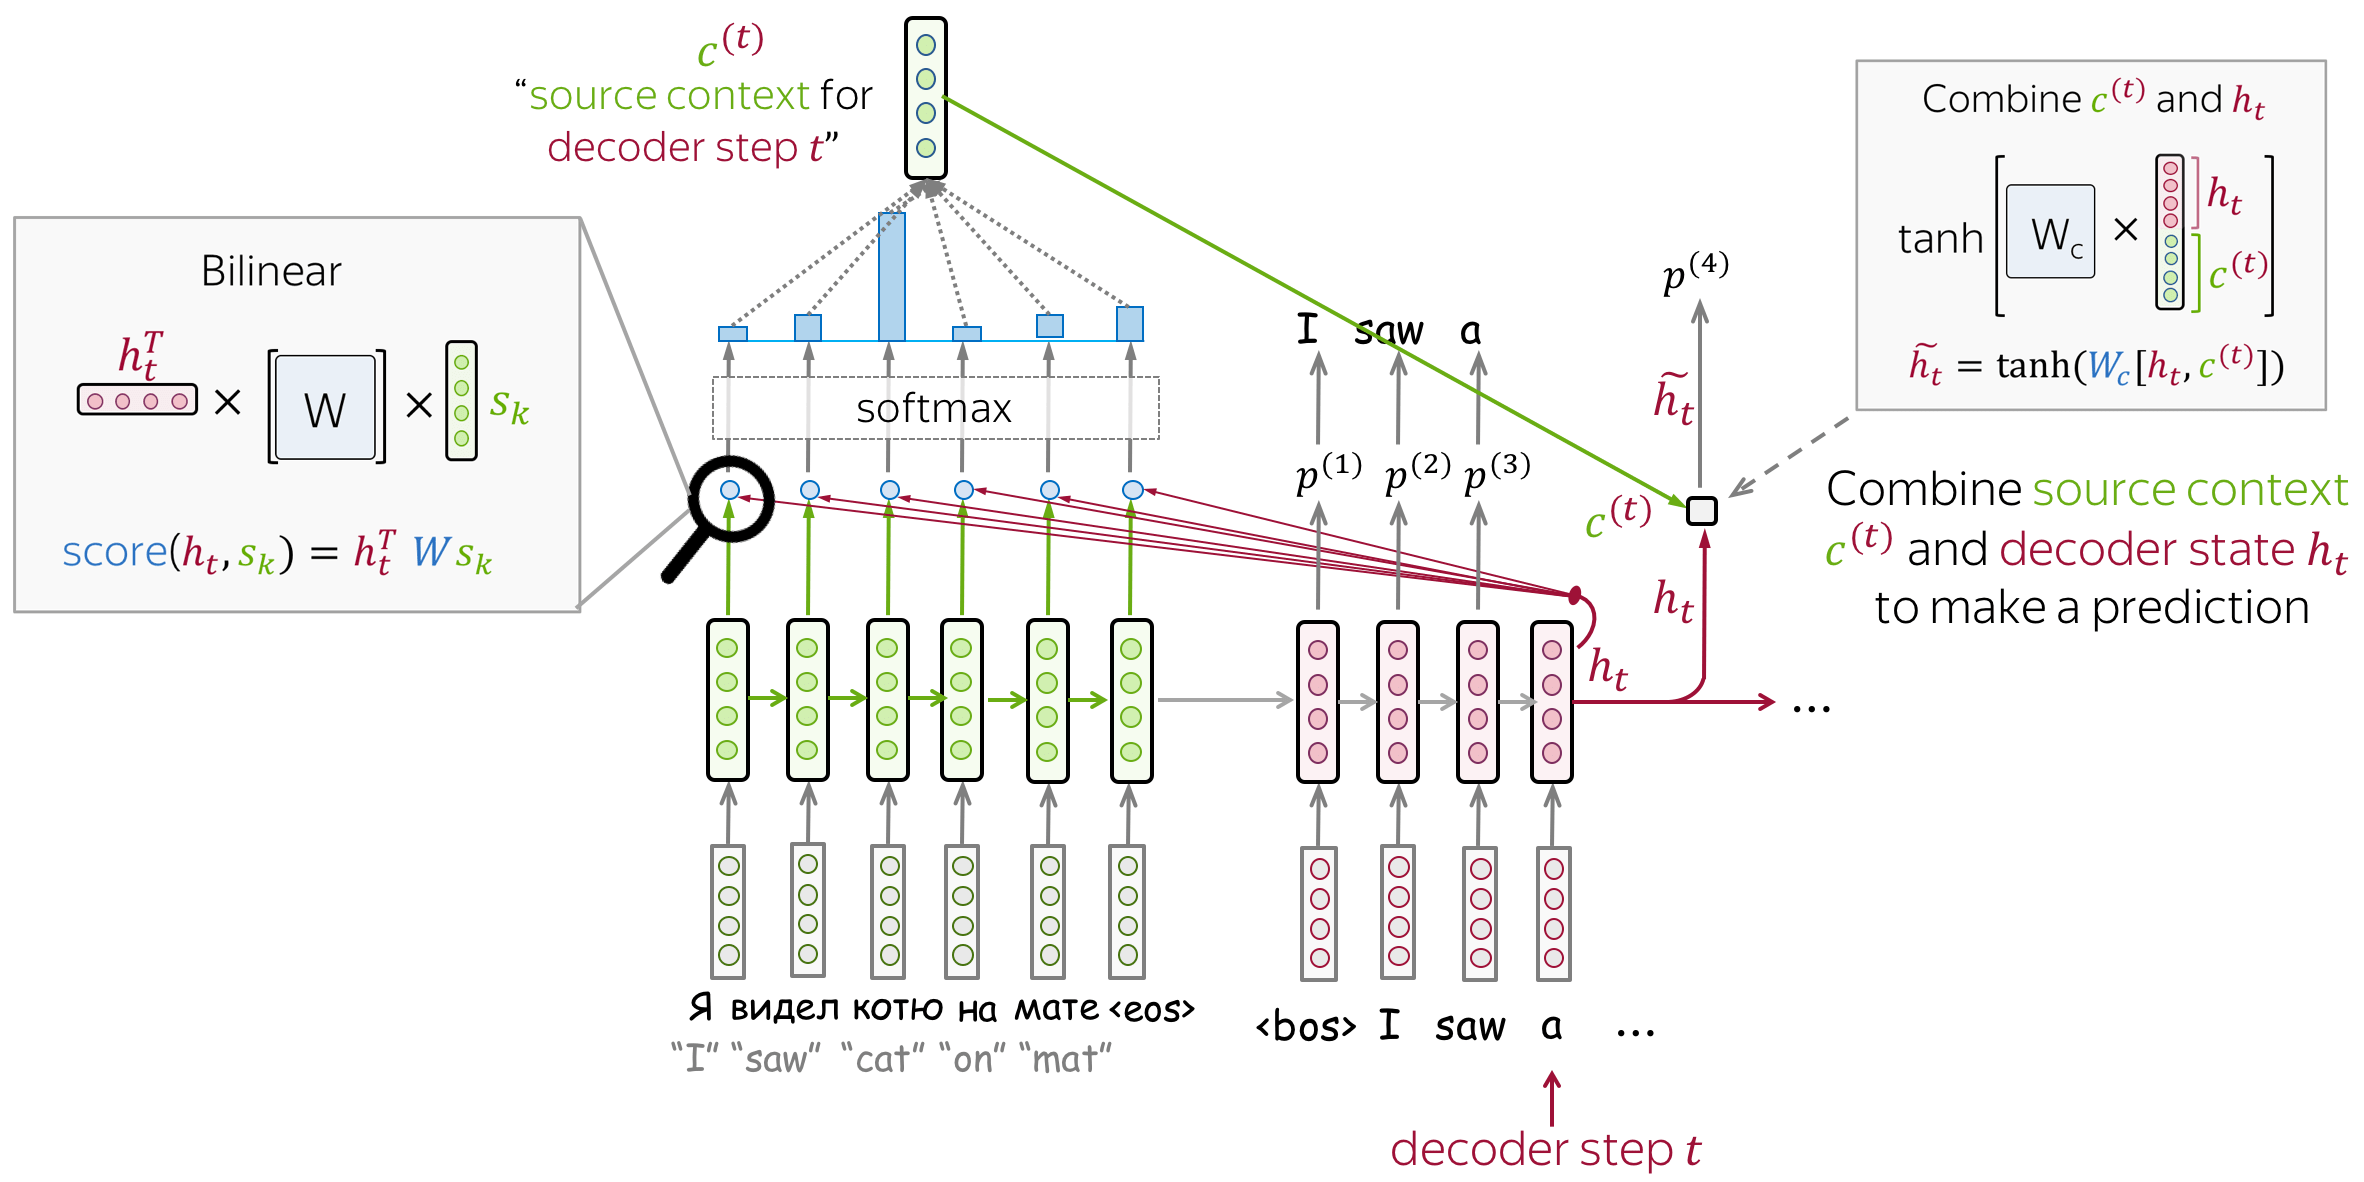

- Define the model described above using the Functional API.

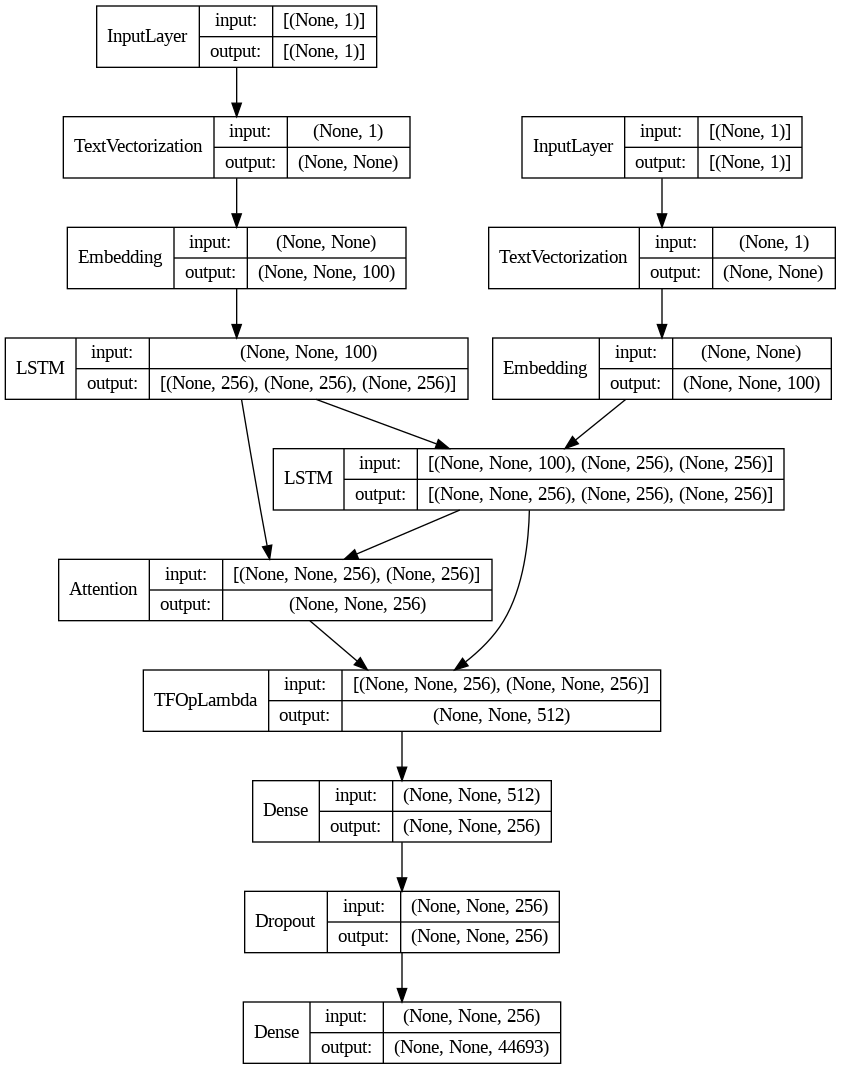

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session, concatenate

hidden_dim = 256
embed_dim = 100

clear_session()

#define an input sequence and process it
encoder_inputs = Input(shape=(1,), dtype='string', name = 'encoder_inputs')
encoder_inputs_vec = src_vectorizer(encoder_inputs)
encoder_inputs_emb = Embedding(input_dim=src_vocab_size, output_dim=embed_dim, mask_zero=True)(encoder_inputs_vec)
#define the encoder lstm
#this time we need the encoder_outputs since they are involved in the attention computation
encoder_outputs, state_h, state_c = LSTM(units=hidden_dim, return_state=True, dropout=0.5)(encoder_inputs_emb)
encoder_states = [state_h, state_c]

#define the decoder, using encoder_states as initial state
decoder_inputs = Input(shape=(1,), dtype='string', name = 'decoder_inputs')
decoder_inputs_vec = trg_vectorizer(decoder_inputs)
decoder_inputs_emb = Embedding(input_dim=trg_vocab_size, output_dim=embed_dim, mask_zero=True)(decoder_inputs_vec)
#we set up our decoder to return full output sequences, and to return internal states as well
#we don't use the return states in the training model, but we will use them in inference
decoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_emb, initial_state=encoder_states)

#attention
#the Keras Attention layer claims to use the Luong style attention explained above
#however it uses a simple dot product to compute the attention score as opposed to Luong's bilinear function
#we will keep it that way for simplicity
attention = Attention()
#query = decoder_outputs (batch_size, 1, hidden_dim)
#value = encoder_outputs (batch_size, src_len, hidden_dim)
attention_output = attention([decoder_outputs,encoder_outputs])
#combine attention_output with decoder_outputs
decoder_outputs_attn = concatenate([attention_output, decoder_outputs])
attention_dense = Dense(units=hidden_dim, activation='tanh', use_bias=False)
decoder_outputs_combined = attention_dense(decoder_outputs_attn)

#use a dense layer to classify each output as one of the words in the vocab
decoder_outputs_combined = Dropout(0.5)(decoder_outputs_combined)
decoder_dense = Dense(units=trg_vocab_size, activation='softmax')
outputs = decoder_dense(decoder_outputs_combined)

#define and visualize the end-to-end model
model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(loss=custom_sparse_categorical_crossentropy, optimizer='adam')

plot_model(model, show_shapes=True, show_layer_names=False)

- Train the model and plot the training and validation loss history.

Epoch 1/5
135/135 [==============================] - 115s 779ms/step - loss: 8.9870 - val_loss: 8.6835
Epoch 2/5
135/135 [==============================] - 97s 718ms/step - loss: 8.5825 - val_loss: 8.5229
Epoch 3/5
135/135 [==============================] - 94s 697ms/step - loss: 8.4206 - val_loss: 8.3617
Epoch 4/5
135/135 [==============================] - 94s 695ms/step - loss: 8.2712 - val_loss: 8.2032
Epoch 5/5
135/135 [==============================] - 93s 690ms/step - loss: 8.1194 - val_loss: 8.0516


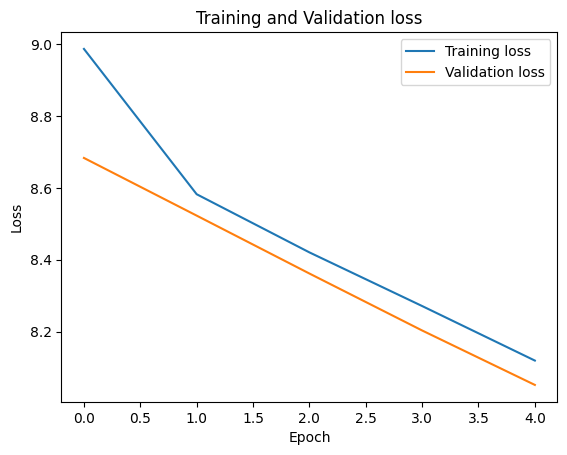

In [30]:
history = model.fit([X_train_enc, X_train_dec], y_train, epochs=5, batch_size=1024, validation_split=0.2)

#Plot training and validation loss history
plt.figure()
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

- Similarly to the above, define the inference model and translation routine.

In [31]:

encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs = Input(shape=(1,), dtype='string', name = 'decoder_inputs')
decoder_inputs_vec = trg_vectorizer(decoder_inputs)
decoder_inputs_emb = Embedding(input_dim=trg_vocab_size, output_dim=embed_dim, mask_zero=True)(decoder_inputs_vec)
encoder_outputs_input = Input(shape=(1, hidden_dim), name="encoder_outputs_input")

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_emb, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

attention_output = attention([decoder_outputs,encoder_outputs])
decoder_outputs_attn = concatenate([attention_output, decoder_outputs])
decoder_outputs_combined = attention_dense(decoder_outputs_attn)
output = decoder_dense(decoder_outputs_combined)

decoder_model = Model([decoder_inputs] + decoder_states_inputs + [encoder_outputs], [output] + decoder_states)

In [32]:
import tensorflow as tf

trg_vocab = trg_vectorizer.get_vocabulary()

def translate_sentence(input_seq, target=None):
    print('Source: ' + input_seq)
    if target is not None:
        print('Target: ' + target)

    #convert string to array
    input_seq = np.array(input_seq).reshape(1,1)
    #encode
    encoder_outputs, state_h, state_c  = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    #populate the first token of target sequence with the start token
    dec_in = tf.reshape(tf.constant(['<SOS>']), (1,1))
    decoded_sentence = ''
    stop_condition = False

    while not stop_condition:
        #here we also pass the encoder_outputs to the decoder to compute attention
        output_tokens, h, c = decoder_model.predict([dec_in] + states_value + [encoder_outputs])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = trg_vocab[sampled_token_index]
        #store output
        decoded_sentence = decoded_sentence + ' ' + sampled_word

        #stop condition either hit max length or find stop token
        #stop token is eos and not <EOS> due to text normalization
        if (sampled_word == 'eos' or len(decoded_sentence.split()) > 30):
            stop_condition = True

        #update the next decoder input
        dec_in = tf.reshape(tf.constant([sampled_word]), (1,1))

        #update states
        states_value = [h, c]

    print('Translation: ' + decoded_sentence)
    print('****************************************************')

In [33]:
translate_sentence(X_test_enc[20], y_test[20])
translate_sentence(X_test_enc[200], y_test[200])
translate_sentence(X_test_enc[450], y_test[450])
translate_sentence(X_test_enc[788], y_test[788])

Source: <SOS> I hate what I've become. <EOS>
Target: Je déteste ce que je suis devenue. <EOS>
1/1 [==============================] - 0s 21ms/step
Translation:  je <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
****************************************************
Source: <SOS> We've forgotten something. <EOS>
Target: Nous avons oublié quelque chose. <EOS>
1/1 [==============================] - 0s 23ms/step
Translation:  je <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
****************************************************
Source: <SOS> I returned to my seat. <EOS>
Target: J'ai regagné mon siège. <EOS>
1/1 [==============================] - 0s 26ms/step
Translation:  je <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos

References:
- Tensorflow and Keras documentation.
- [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html).
- [Sequence to Sequence (seq2seq) and Attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html).